# ARID1A phosphoproteomics cis comparison

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

## Step 2: Find the frequently mutated genes for Endometrial Cancer

Enter the type of cancer and the cutoff for mutation frequency that you would like to use.

In [2]:
en_object = cptac.Endometrial()
desired_cutoff = .2

endometrial_freq_mut = al.get_frequently_mutated(en_object, cutoff = desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(endometrial_freq_mut), '\n')
endometrial_freq_mut.loc[endometrial_freq_mut['Gene'] == 'ARID1A']

                                    

Number of Frequently Mutated Genes: 10 



,Gene,Unique_Samples_Mut,Missence_Mut,Truncation_Mut
0,ARID1A,0.452632,0.136842,0.4


## Step 3: Select ARID1A, a frequently mutated gene

In [3]:
gene = 'ARID1A'

## Step 4: Select phosphoproteomics

In [4]:
omics = en_object.get_phosphoproteomics()

## Step 5: cis comparison 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. The first three steps are found in the format_phospho_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

In [5]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
omics_and_mut = en_object.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = gene)

# Step 2 - Create the binary column needed to do the comparison
omics_and_mut['binary_mutations'] = omics_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - format for loop (only phospho)
tumors = omics_and_mut.loc[omics_and_mut['Sample_Status'] == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho = tumors.drop(columns_to_drop, axis = 1)
only_phospho = binary_phospho.drop('binary_mutations', axis = 1)


In [6]:
omics_col_list = list(only_phospho.columns) 
significant_pval_results = al.wrap_ttest(binary_phospho, 'binary_mutations', omics_col_list)
print(significant_pval_results)

                       Comparison       P_Value
0  ARID1A-S1755_phosphoproteomics  7.963747e-10
1  ARID1A-S1184_phosphoproteomics  4.338936e-07
2  ARID1A-S1604_phosphoproteomics  1.501846e-06
3   ARID1A-S363_phosphoproteomics  3.402219e-05
4   ARID1A-S696_phosphoproteomics  1.869464e-04
5  ARID1A-S1751_phosphoproteomics  1.897477e-04
6  ARID1A-S1600_phosphoproteomics  3.103462e-04
7   ARID1A-S702_phosphoproteomics  5.568366e-04


C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [7]:
# Create data frame for boxplot with all significant sites
phospho_list = list(significant_pval_results['Comparison'])
all_data = pd.DataFrame()
for phospho_name in phospho_list:
    real = omics_and_mut[[phospho_name, "binary_mutations"]].dropna(axis = 0) #drop rows with missing measurements
    concise_phospho_name = phospho_name.replace('_phosphoproteomics', '') #shorten col names
    real = real.assign(specific_phospho = concise_phospho_name)
    real = real.rename(columns={ real.columns[0]: "phosphoproteomics" })
    all_data = pd.concat([real, all_data], axis = 0)

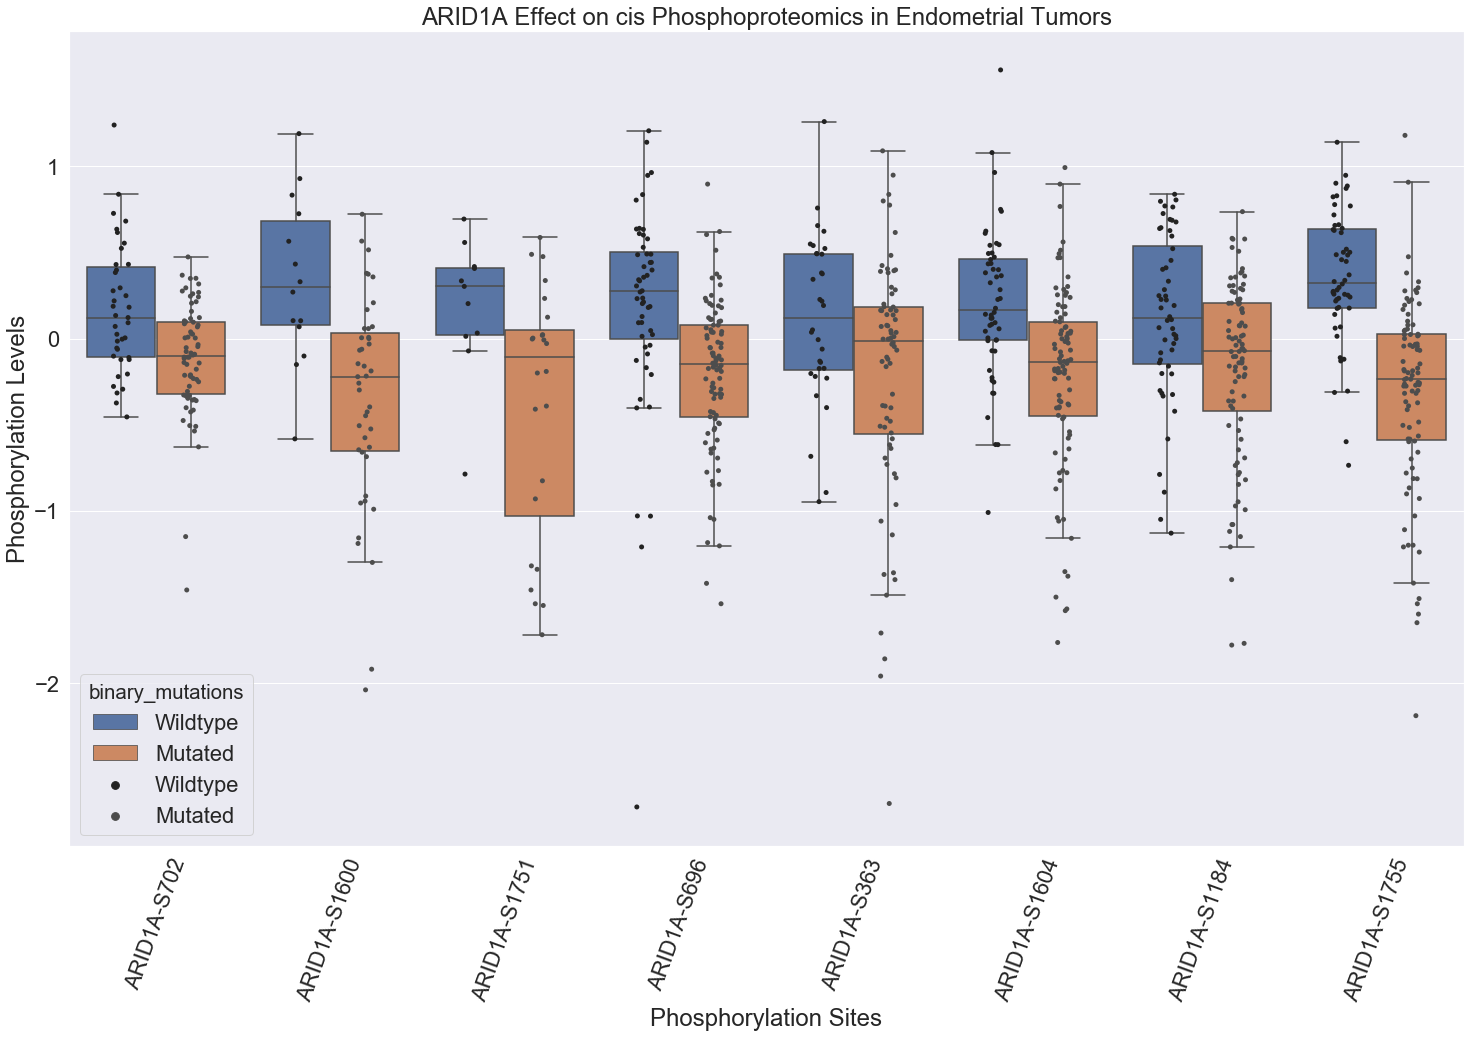

In [8]:
# Step 5 - Create boxplot to compare wildtype and mutated effect on omics data
plt.rcParams['figure.figsize']=(25,15) #size of plot
sns.set(font_scale = 2)
en_cis_boxplot = sns.boxplot(data = all_data, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Mutated"], showfliers = False)  
en_cis_boxplot.set_title(gene + " Effect on cis Phosphoproteomics in Endometrial Tumors")
en_cis_boxplot = sns.stripplot(data= all_data, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Mutated"], jitter = True, color = ".3", dodge = True)
en_cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
en_cis_boxplot.set_xticklabels(en_cis_boxplot.get_xticklabels(),rotation=70)
plt.show()
plt.clf()
plt.close()

The phosphorylation levels decrease in the mutated samples compared to the wildtype.

Mutation type comparison

In [9]:
formated_phospho_mut_type = f.get_missence_truncation_comparison(en_object, 'phosphoproteomics', gene)

In [10]:
significant_pval_results = al.wrap_ttest(formated_phospho_mut_type, 'binary_mutations', omics_col_list)
print(significant_pval_results)

No significant comparisons.
None


No significant comparisons for mutation type.

# Repeat with the Colon dataset

Go through the same process, this time using the Colon dataset. We will only print five genes from the frequently mutated data frame for simplicity.

In [11]:
colon_object = cptac.Colon()
desired_cutoff = .2

colon_freq_mut = al.get_frequently_mutated(colon_object, cutoff = desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(colon_freq_mut), '\n')
colon_freq_mut.loc[colon_freq_mut['Gene'] == 'ARID1A']

                                    

Number of Frequently Mutated Genes: 39 



,Gene,Unique_Samples_Mut,Missence_Mut,Truncation_Mut
3,ARID1A,0.237113,0.072165,0.185567


In [12]:
gene = 'ARID1A'

co_omics = colon_object.get_phosphoproteomics()

In [13]:
omics_mutations = colon_object.join_omics_to_mutations(
        mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = gene)

Phosphoproteomic data for ARID1A does not exist for the endometrial dataset.

# Visualize Pancancer effects

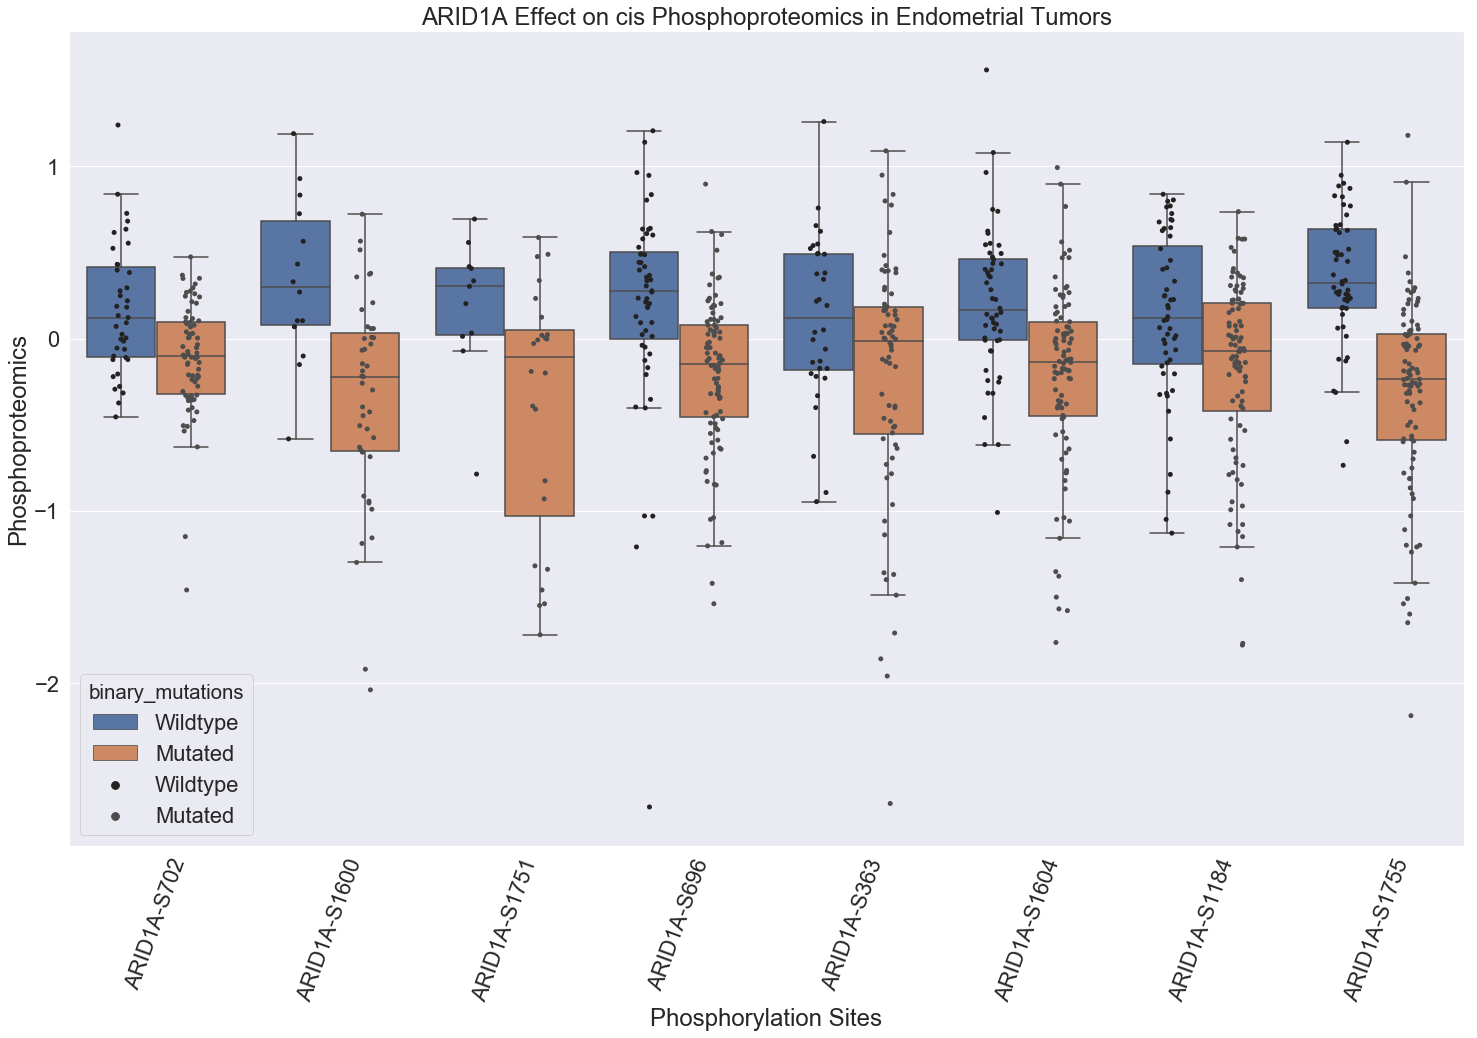

In [14]:
# Step 5 - Create boxplot to compare wildtype and mutated effect on omics data
plt.rcParams['figure.figsize']=(25,15) #size of plot
sns.set(font_scale = 2)
en_cis_boxplot = sns.boxplot(data = all_data, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Mutated"], showfliers = False)  
en_cis_boxplot.set_title(gene + " Effect on cis Phosphoproteomics in Endometrial Tumors")
en_cis_boxplot = sns.stripplot(data= all_data, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Mutated"], jitter = True, color = ".3", dodge = True)
en_cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphoproteomics")
en_cis_boxplot.set_xticklabels(en_cis_boxplot.get_xticklabels(),rotation=70)
plt.show()
plt.clf()
plt.close()

# Analysis of Results

The endometrial dataset showed a decrease in the muated ARID1A phophorylation levels  accross all eight signifcant sites. The colon dataset contained no data for ARID1A phosphoproteomics.